## Поиск наиболее прибыльного региона для добычи нефти при помощи ML

<a id='content'></a>

<div> 

**Цель:**   С помощью модели линейной регрессии определить регион с максимальной суммарной прибылью скважин.

**Исходные данные и ход исследования** 

- В работе используются данные с пробами нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. 
- Для обучения модели будет использоваться линейная регрессия (остальные — недостаточно предсказуемые). С помощью машинного обучения будет отобрано 200 лучших скважин для разработки в каждом регионе.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков будут оставлены лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них будет выбран регион с наибольшей средней прибылью.
- Возможная прибыль и риски анализируются с использованием техники Bootstrap.

**Содержание**:

* <a href='#know_the_data'>Знакомство с данными</a> </br>
* <a href='#data_preprocessing'>Предобработка данных</a> </br>
* <a href='#data_analysis'>Исследовательский анализ данных</a></br>
* <a href='#Correlation_analysis'>Корреляционный анализ</a></br> 
* <a href='#ML'>Предсказание запасов сырья с помощью ML</a></br>
* <a href='#profit_calculation'>Расчет прибыли</a></br>
* <a href='#Well_selection'>Отбор скважин, расчет рисков и прибыли.</a></br>
* <a href='#conclusions'>Выводы</a></br> 

</div>



In [1]:
!pip install pandas==2.2.2 seaborn==0.13.2 numba==0.60.0 numpy==1.26.4 matplotlib==3.9.0 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install --upgrade scikit-learn==1.2.2 -q

In [3]:
#Загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import warnings
import sklearn
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

sns.set_context('notebook', rc={
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'legend.fontsize': 12,
    'legend.title_fontsize': 12
})

<div> 

*Функции, используемые в работе*

</div>

In [4]:
# Функция для построения гистограмм
def plot_histograms(df, columns, rows=2):
    """
    Строит гистограммы для указанных числовых столбцов в DataFrame.

    Args:
        df: DataFrame с данными.
        columns: Список названий числовых столбцов.
        rows: Количество рядов в сетке графиков.
    """
    num_plots = len(columns)
    cols = num_plots // rows + (num_plots % rows > 0)  
    fig, axes = plt.subplots(nrows=rows, 
                             ncols=cols, 
                             figsize=(cols*5, rows*4))
    axes = axes.flatten()  

    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()


#Функция для загрузки дата сета, 
#file_name - строка с названием файла для загрузки, 
#df_name - название для загружаемого датасета
#sep - разделитель, по умолчанию ','
#graf - строим ли графики

def loading_data(file_name, df_name, sep=',', graf=True, missingno=False, figsize=(15,10), bins=30):
    
    try:
        df = pd.read_csv('files/'+  file_name, sep=sep) 
    except:
        df = pd.read_csv('/datasets/' + file_name, sep=sep) 
    
    pd.set_option("display.max_columns", None)
    
    print(df_name)
    display(df.head(5))
    print('-'*80)
    print('Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти ')
    print()
    print(df.info())
    print('-'*80)
    print('Оценим количество пропущенных значений в каждом столбце')
    print()
    display(df.isna().sum())
    
    if missingno == True:
        print('-'*80)
        print('Визуализируем пропуски в данных')
        msno.matrix(df, figsize = (10,8))
    if graf == True:
        plt.show()
        print('-'*80)
        print('Визуализируем общие данные')
        if 'id' in df.columns:
            df_new = df.drop(columns=['id'])
        else:
            df_new = df

        # Вызываем функцию, указав желаемое количество рядов
        numeric_cols = df_new.select_dtypes(include=['number']).columns
        rows = math.ceil(len(numeric_cols)/3)
        plot_histograms(df_new, numeric_cols, rows=rows)  # Например, 3 ряда
        
        #g.fig.set_size_inches(figsize)
        
        plt.show()
        #label = 'Гистограмма распределения '+ my_title
        #plt.title(label=label, fontsize = 24, y = 1, color = 'midnightblue')  
        #sns.set_context(rc={'legend.fontsize': 24})
          

    return df

In [5]:
#Предобработка, удаление явных дубликатов
def remove_duplicates(data, title):
    num_duplicates = data.duplicated().sum()
    if num_duplicates != 0:
        print('Количество явных дубликатов в ', title, ':', data.duplicated().sum())
        print('Размер', title, 'до удаления дубликатов:', data.shape)
        data = data.drop_duplicates(keep = 'first', 
                                    subset=data.columns.difference(['id']))
        print('Размер', title, 'после удаления дубликатов:', data.shape)
        return data
    else:
        print('Явные дубликаты в', title, 'отсутсвуют')
        return data

In [6]:
'''
Исследовательский анализ данных
Гистограмма и ящик с усами
data - series
title - название для графика
'''
def my_plot(data,x_column, hue_column, my_title, bins=50):
    sns.histplot(data, 
                 x=data[x_column],
                 hue=hue_column, bins=50, 
                 palette="Set1", 
                 linewidth=0.3, 
                 kde=False, 
                 legend=True,
                 stat='density', common_norm=True)
    sns.set_context(rc={'legend.fontsize': 24})
    label = 'Гистограмма распределения '+ my_title
    plt.title(label=label, fontsize = 24, y = 1, color = 'midnightblue')
    plt.grid(True)
    plt.rcParams['font.size'] = 20
    plt.ylabel('Плотность вероятности', fontsize = 20)
    #plt.legend()

<a href='#content'>Вернуться к оглавлению</a> 

<a id='#know_the_data'></a> </br>

### Знакомство с данными

df_1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце



id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


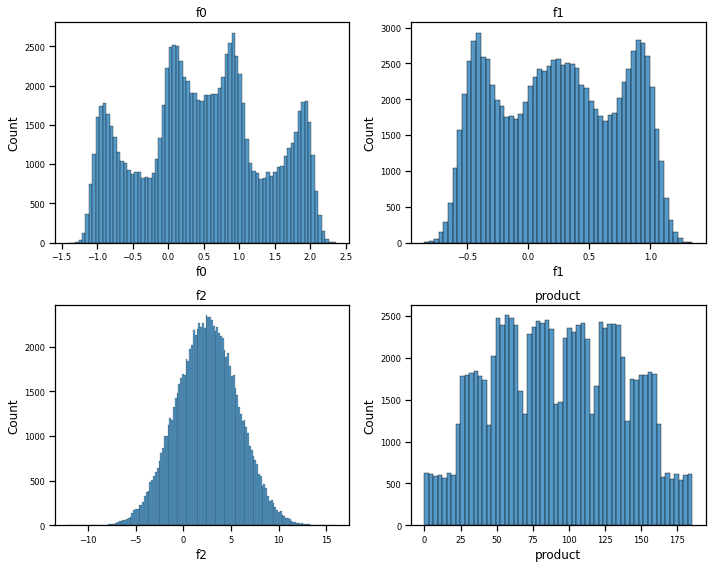

In [7]:
df_1 = loading_data('geo_data_0.csv', 'df_1')

**Регион 1**

1. Распределение признака **f0** данных приблизительно симметричное относительно нуля. Центр распределения данных находится в значении 0.5. Данные распределены в диапазоне примерно от -1.5 до 2.5. Распределение можно охарактеризовать как многомодальное, так как на графике присутствует несколько пиков. Это говорит о том, что в данных есть несколько групп значений, которые встречаются чаще других.
2. Гистограмма признака **f1** демонстрирует многомодальное распределение, то есть имеет несколько пиков. Это говорит о том, что данные не распределены по нормальному закону, а имеют более сложную структуру.Центр распределения находится примерно в районе 0.25-0.35.Данные распределены в диапазоне примерно от -0.5 до 1.2.Распределение слегка положительно скошено, то есть правый хвост распределения длиннее левого.
3. Гистограмма признака **f2** демонстрирует приблизительно нормальное распределение. Это означает, что большинство значений сосредоточено вокруг среднего значения, а частота встречаемости значений уменьшается по мере удаления от среднего. Центр распределения находится примерно в районе 2-3.Данные распределены в диапазоне примерно от -10 до 15. Распределение слегка положительно скошено, то есть правый хвост распределения немного длиннее левого.
4. Гистограмма распределения объёма запасов в скважине демонстрирует многомадальное распределение. Центр распределения приблизительн в районе 90 тыс. баррелей. Данные распределены в диапазоне от 0 до 175 тыс. баррелей.

df_2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце



id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


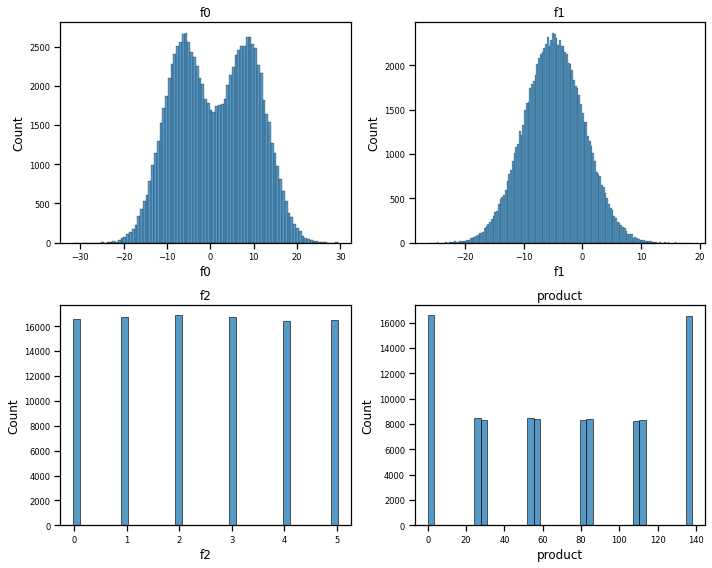

In [8]:
df_2 = loading_data('geo_data_1.csv', 'df_2')

**Регион 2**
1. Распределение признака **f0** можно охарактеризовать как многомодальное, так как на графике присутствует 2 пика, симметричных относительно нуля. Данные распределены в диапазоне от -30 до 30.
2. Гистограмма признака **f1** демонстрирует приблизительно нормальное распределение. Центр распределения смещен влево. Данные распределены в диапазоне примерно от -30 до 20. Распределение отрицательно скошено, то есть левый хвост распределения немного длиннее правого.
3. Гистограмма признака **f2** принимает только целые значения от 0 до 5. Это означает, что данные являются дискретными, а не непрерывными. Каждый столбик примерно одинаковой высоты, что указывает на равномерное распределение данных. На гистограмме отсутствуют отдельные столбцы, значительно отличающиеся по высоте от остальных, что говорит об отсутствии выбросов в данных.
4. Гистограмма распределения объёма запасов в скважине демонстрирует нескольких высоких, узких столбцов, расположенных на равном расстоянии друг от друга. Столбики с 0 и максимальным значенем (140 тыс. баррелей) самые многочисленные. Остальные столбики примерно одинаковой высоты, что указывает на равномерное распределение данных. На гистограмме отсутствуют отдельные столбцы, значительно отличающиеся по высоте от остальных, что говорит об отсутствии выбросов в данных. 

df_3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце



id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


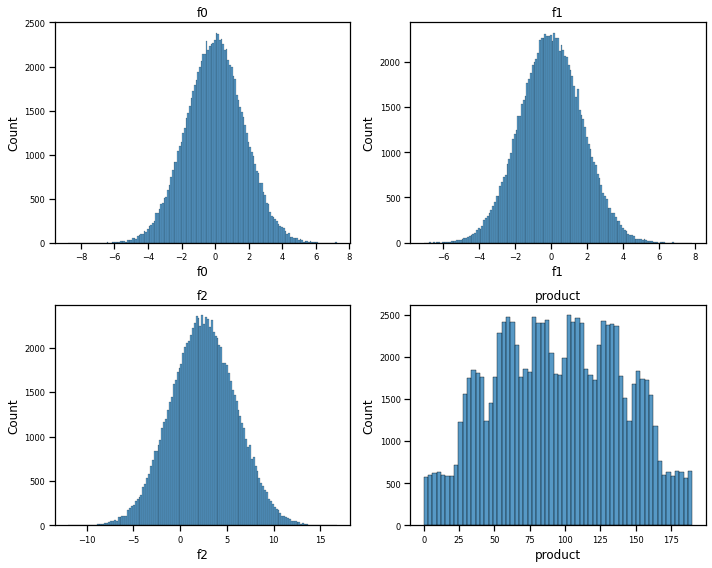

In [9]:
df_3 = loading_data('geo_data_2.csv', 'df_3')

**Регион 3**

1. Распределение признака **f0 и f1** демонстрирует приблизительно нормальное распределение. Среднее значение расположено в районе нуля. Данные распределены в диапазоне примерно от -8 до 8 и от -6 до 6 соответсвенно.
2. Гистограмма признака **f2** демонстрирует приблизительно нормальное распределение. Центр распределения находится примерно в районе 2-3.Данные распределены в диапазоне примерно от -10 до 15. Распределение слегка положительно скошено, то есть правый хвост распределения немного длиннее левого. Распределение признака повторяет данные для региона 1.
3. Гистограмма распределения объёма запасов в скважине демонстрирует многомадальное распределение. Центр распределения приблизительн в районе 90 тыс. баррелей. Данные распределены в диапазоне от 0 до 175 тыс. баррелей. Гистограмма похожа на гистограмму распределения запасов региона 1.

**Общая предварительная оценка данных:**

- набор данных достаточен для анализа
- пропуски отсутсвуют
- для df_2 можно оптимизировать типы данных
- выборка репрезентативна.
- длинные хвосты на некоторых гистограммах могут говорить о присутсвии аномалий или выбросов.

 <a id='data_preprocessing'></a> </br>

###  Предобработка данных

In [10]:
df_1 = remove_duplicates(df_1, 'Регион 1')
df_2 = remove_duplicates(df_2, 'Регион 2')
df_3 = remove_duplicates(df_3, 'Регион 3')

Явные дубликаты в Регион 1 отсутсвуют
Явные дубликаты в Регион 2 отсутсвуют
Явные дубликаты в Регион 3 отсутсвуют


<a href='#content'>Вернуться к оглавлению</a> 

<a id='data_analysis'></a></br>

## Исследовательский анализ данных

In [13]:
df_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [14]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [15]:
df_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Значения входных признаков и целевого признака региона 2 сильно разнице с регионом 1 и 3. 

In [16]:
df_1['region'] = 1
df_2['region'] = 2
df_3['region'] = 3
df = pd.concat([df_1, df_2, df_3], axis=0, join='outer', ignore_index=True)
print(df.head())
print(df.tail())

      id        f0        f1        f2     product  region
0  txEyH  0.705745 -0.497823  1.221170  105.280062       1
1  2acmU  1.334711 -0.340164  4.365080   73.037750       1
2  409Wp  1.022732  0.151990  1.419926   85.265647       1
3  iJLyR -0.032172  0.139033  2.978566  168.620776       1
4  Xdl7t  1.988431  0.155413  4.751769  154.036647       1
           id        f0        f1        f2     product  region
299995  4GxBu -1.777037  1.125220  6.263374  172.327046       3
299996  YKFjq -1.261523 -0.894828  2.524545  138.748846       3
299997  tKPY3 -1.199934 -2.957637  5.219411  157.080080       3
299998  nmxp2 -2.419896  2.417221 -5.548444   51.795253       3
299999  V9kWn -2.551421 -2.025625  6.090891  102.775767       3


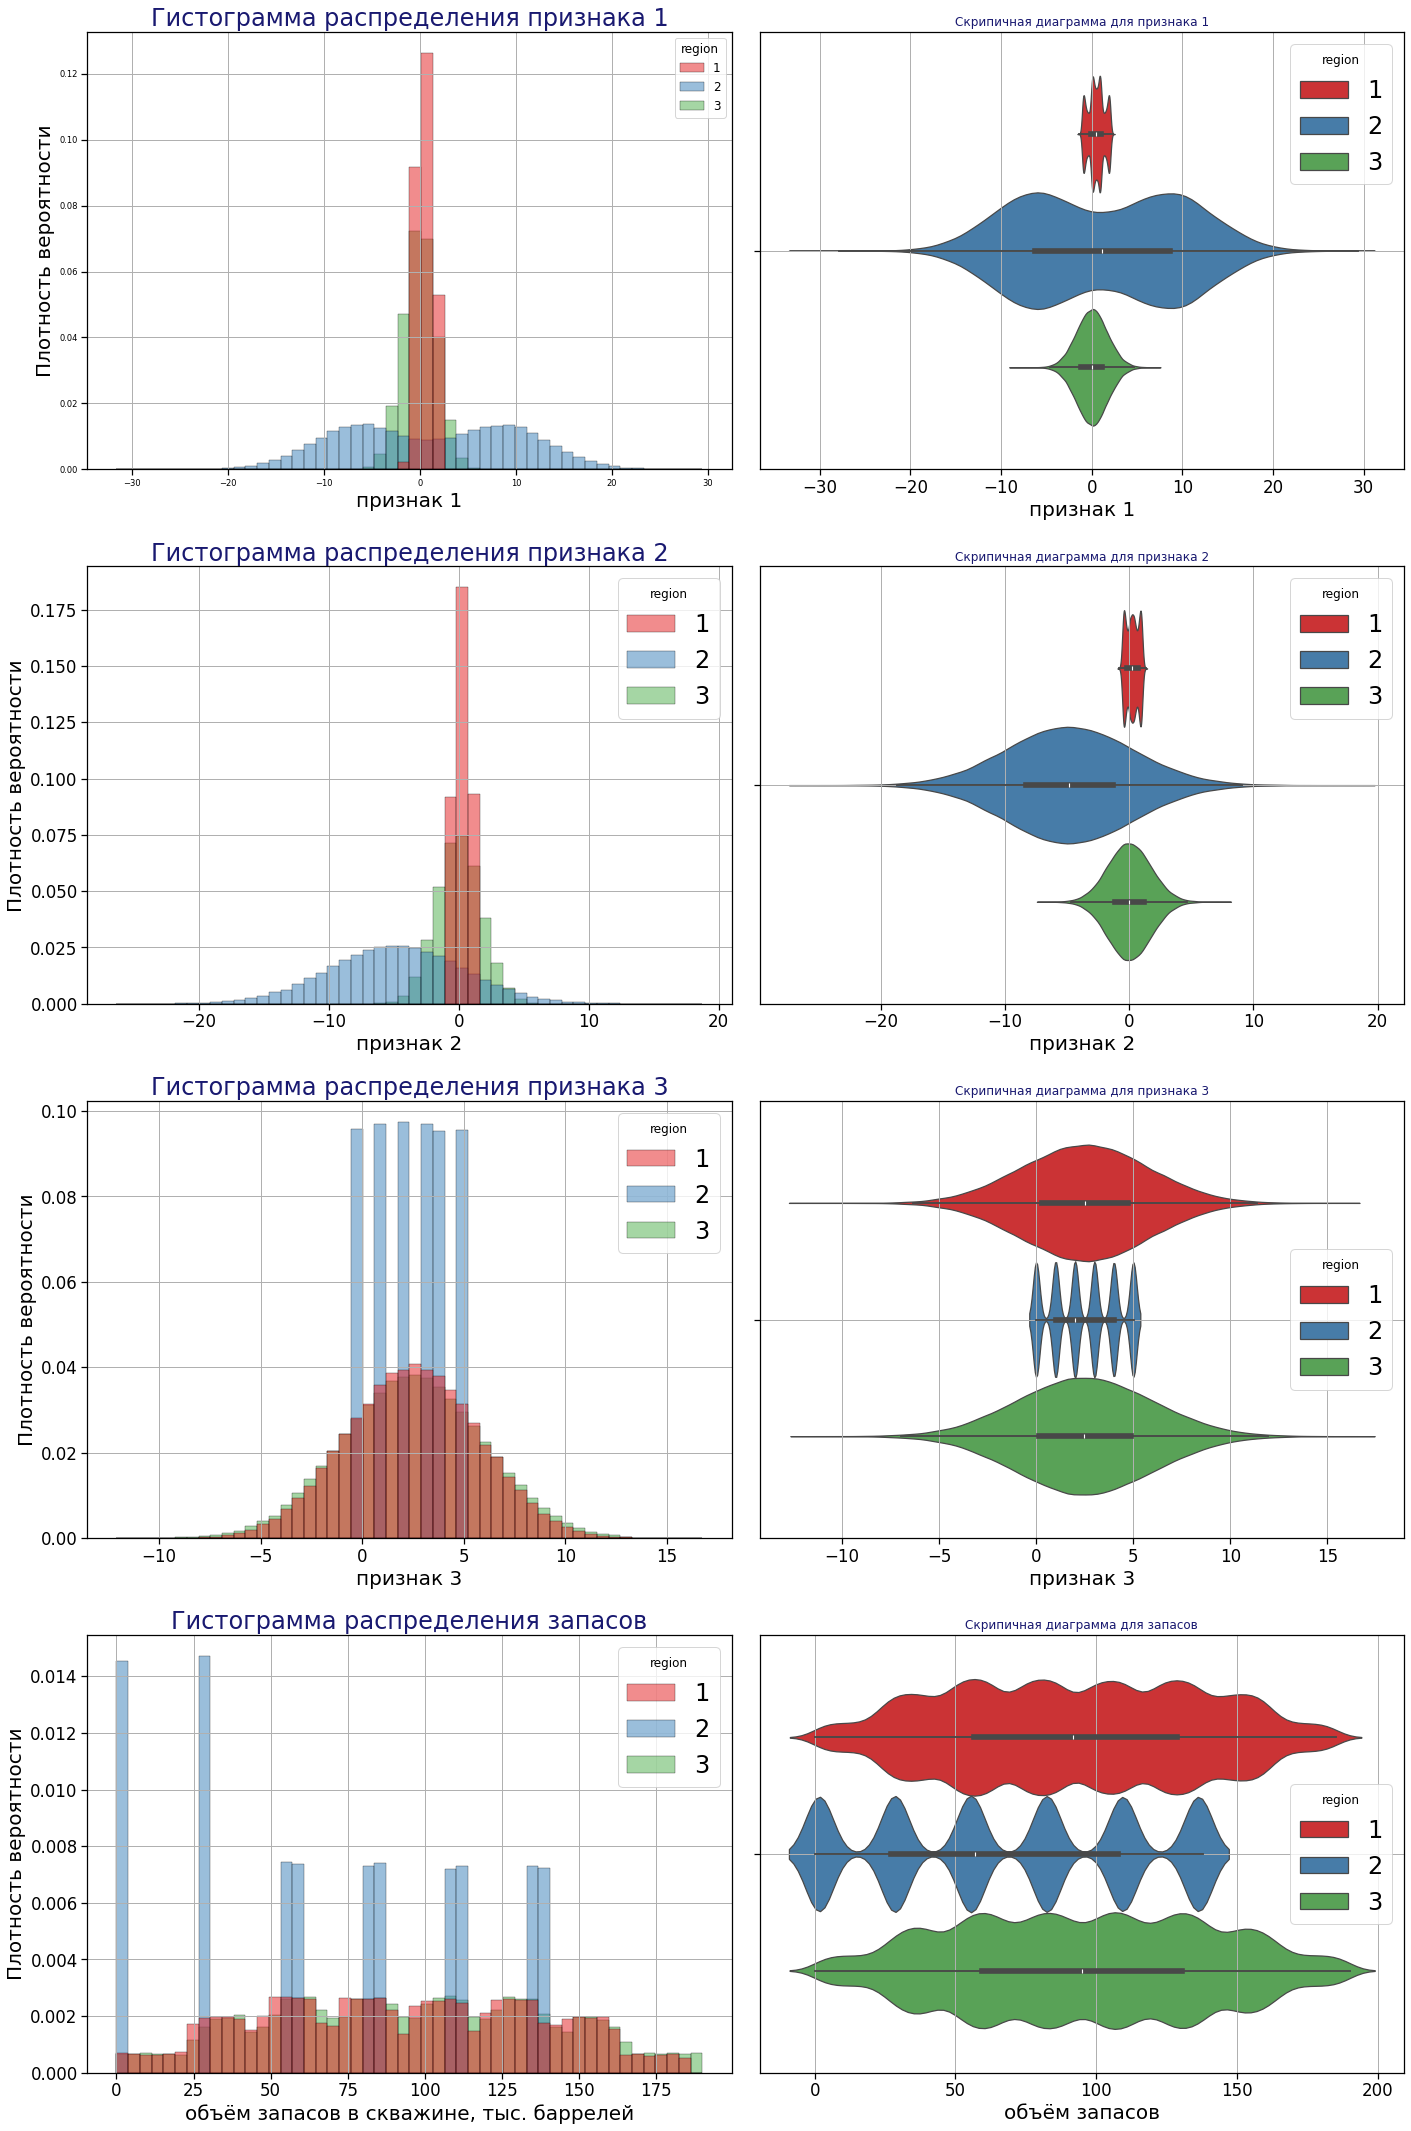

In [17]:
plt.figure(figsize=(20,30))
plt.subplot(4, 2, 1)
my_plot(data = df, 
        x_column = 'f0', 
        hue_column = df['region'],
        my_title = 'признака 1')
plt.xlabel('признак 1', fontsize = 20)

plt.subplot(4, 2, 2)
sns.violinplot(df, x=df['f0'], hue=df['region'], palette='Set1')
plt.grid(True)
plt.title('Скрипичная диаграмма для признака 1', color = 'midnightblue')
plt.xlabel('признак 1', fontsize = 20)

plt.subplot(4, 2, 3)
my_plot(data = df, 
        x_column = 'f1', 
        hue_column = df['region'],
        my_title = 'признака 2')
plt.xlabel('признак 2', fontsize = 20)

plt.subplot(4, 2, 4)
sns.violinplot(df, x=df['f1'], hue=df['region'], palette='Set1')
plt.grid(True)
plt.title('Скрипичная диаграмма для признака 2', color = 'midnightblue')
plt.xlabel('признак 2', fontsize = 20)

plt.subplot(4, 2, 5)
my_plot(data = df, 
        x_column = 'f2', 
        hue_column = df['region'],
        my_title = 'признака 3')
plt.xlabel('признак 3', fontsize = 20)

plt.subplot(4, 2, 6)
sns.violinplot(df, x=df['f2'], hue=df['region'], palette='Set1')
plt.grid(True)
plt.title('Скрипичная диаграмма для признака 3', color = 'midnightblue')
plt.xlabel('признак 3', fontsize = 20)

plt.subplot(4, 2, 7)
my_plot(data = df, 
        x_column = 'product', 
        hue_column = df['region'],
        my_title = 'запасов')
plt.xlabel('объём запасов в скважине, тыс. баррелей', fontsize = 20)

plt.subplot(4, 2, 8)
sns.violinplot(df, x=df['product'], hue=df['region'], palette='Set1')
plt.grid(True)
plt.title('Скрипичная диаграмма для запасов', color = 'midnightblue')
plt.xlabel('объём запасов', fontsize = 20)

plt.tight_layout()
plt.show()

Для признака **f0**
- Медиана признака для всех регионов примерно одинакова.
- Есть некоторые различия в форме распределений между регионами. Для региона 2 распределение более широкое, что указывает на большую вариабельность данных в этом регионе.
- Наблюдаются выбросы в области положительных значений.

Для признака **f1**
- Признак 2 в целом распределен приблизительно нормально (колоколообразно) для всех трех регионов.
- Центры распределений для всех трех регионов примерно совпадают и находятся около нуля.
- На скрипичной диаграмме для региона 1 видны выбросы в области положительных значений.

Различия между регионами:
Регион 1: Имеет самый узкий и высокий пик, что указывает на меньшую вариативность данных по сравнению с другими регионами.
Регион 2: Имеет более широкое распределение по сравнению с регионом 1, что говорит о большей вариабельности данных.
Регион 3: Распределение региона 3 похоже на распределение региона 2, но с немного меньшей вариативностью.

Для признака **f2**
- Признак 3 в целом распределен приблизительно нормально для всех трех регионов.
- Центры распределений для всех трех регионов смещены вправо от нуля.

Различия между регионами:
Регион 1: Имеет самый широкий пик и наибольшую вариативность данных среди всех регионов.
Регион 2: Имеет более узкий пик и меньшую вариативность данных по сравнению с регионом 1.
Регион 3: Распределение региона 3 похоже на распределение региона 2, но с еще меньшей вариативностью.


Отличия между признаками:
- Признак 3 имеет смещение центра распределения вправо по сравнению с признаками 1 и 2.
- Признак 3 демонстрирует наибольшую вариативность среди всех трех признаков.

Для **запасов**
- Запасы нефти в разных регионах имеют существенные различия.
- Регион 1 отличается наибольшей долей скважин с большими запасами.
- Регион 3 отличается наименьшей долей скважин с большими запасами.
- Наличие положительного перекоса указывает на то, что большинство скважин имеют относительно небольшие запасы.

<a href='#content'>Вернуться к оглавлению</a> 

 <a id='Correlation_analysis'></a></br> 

## Корреляционный анализ

Посмотрим на корреляцию признаков с целевым признаком для каждого региона.

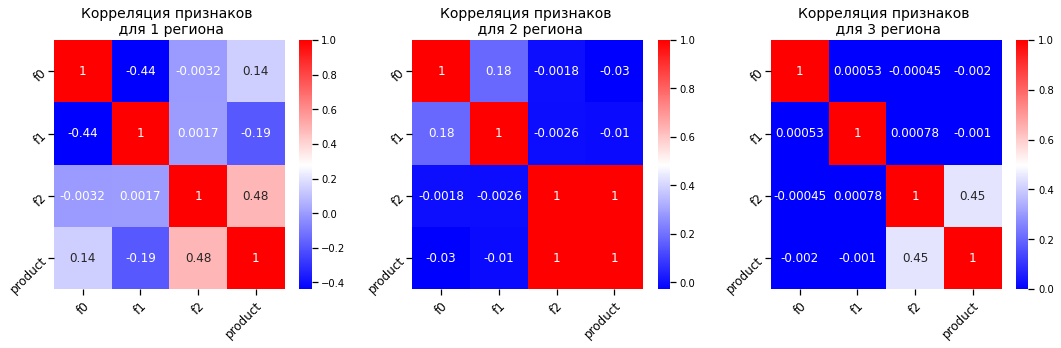

In [18]:
corr_1 = df_1.drop(columns=['id', 'region']).corr()
corr_2 = df_2.drop(columns=['id', 'region']).corr()
corr_3 = df_3.drop(columns=['id', 'region']).corr()

plt.figure(figsize=(15,5))
plt.rcParams['font.size'] = 12
plt.subplot(1, 3, 1)
ax1 = sns.heatmap(corr_1, annot=True, cmap='bwr')
plt.setp(ax1.get_xticklabels(), 
         rotation=45, ha="right",
         rotation_mode="anchor",
         fontsize=12)
plt.setp(ax1.get_yticklabels(), 
         rotation=45, ha="right",
         rotation_mode="anchor",
         fontsize=12)
ax1.set_title("Корреляция признаков \n для 1 региона", fontsize=14)

plt.subplot(1, 3, 2)
ax1 = sns.heatmap(corr_2, annot=True, cmap='bwr')
plt.setp(ax1.get_xticklabels(), 
         rotation=45, ha="right",
         rotation_mode="anchor",
         fontsize=12)
plt.setp(ax1.get_yticklabels(), 
         rotation=45, ha="right",
         rotation_mode="anchor",
         fontsize=12)
ax1.set_title("Корреляция признаков \n для 2 региона", fontsize=14)

plt.subplot(1, 3, 3)
ax1 = sns.heatmap(corr_3, annot=True, cmap='bwr')
plt.setp(ax1.get_xticklabels(), 
         rotation=45, ha="right",
         rotation_mode="anchor",
         fontsize=12)
plt.setp(ax1.get_yticklabels(), 
         rotation=45, ha="right",
         rotation_mode="anchor",
         fontsize=12)
ax1.set_title("Корреляция признаков \n для 3 региона", fontsize=14)

plt.tight_layout()
plt.show()

Анализ матриц корреляций для трех регионов:

- Высокая положительная корреляция между f2 и product во всех регионах: Это наиболее заметная тенденция. Высокий коэффициент корреляции между этими двумя признаками указывает на сильную положительную связь, т.е. при увеличении значения f2, как правило, увеличивается и значение product. Это может свидетельствовать о том, что признак f2 является важным предиктором для значения product.
- Слабая корреляция между другими признаками: Большинство других коэффициентов корреляции близки к нулю, что указывает на отсутствие значимой линейной связи между этими признаками. - Однако, следует отметить, что в первом регионе наблюдается умеренная отрицательная корреляция между признаками f0 и product.


- Высокая корреляция между f2 и product не означает, что изменение f2 обязательно вызывает изменение product. Могут существовать другие скрытые факторы, влияющие на оба признака.
- Нелинейная зависимость: Матрица корреляций отражает только линейную зависимость. Между признаками может существовать нелинейная зависимость, которую не удается обнаружить с помощью коэффициента корреляции.


- Высокая корреляция между f2 и product у региона 2 не свидетельствует о мультиколлинеарности, т.к. один из признаков входной, другой целевой.


Построение графиков рассеяния для пар признаков с высокой корреляцией поможет лучше понять характер их связи.

In [19]:
df.head()

,id,f0,f1,f2,product,region
0,txEyH,0.705745,-0.497823,1.221170,105.280062,1
1,2acmU,1.334711,-0.340164,4.365080,73.037750,1
2,409Wp,1.022732,0.151990,1.419926,85.265647,1
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,1
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,1


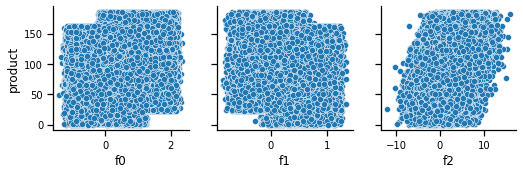

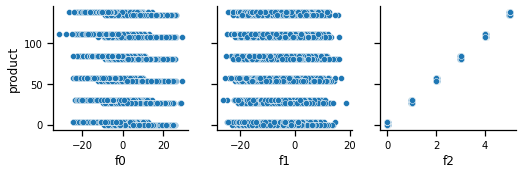

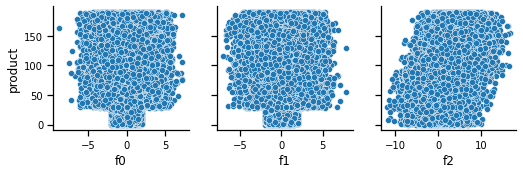

In [20]:

g = sns.PairGrid(data=df_1, 
                x_vars = ['f0', 'f1', 'f2'] ,
                y_vars = 'product', 
                palette = ("pastel")
)

g.map(sns.scatterplot)

g = sns.PairGrid(data=df_2, 
                x_vars = ['f0', 'f1', 'f2'] ,
                y_vars = 'product', 
                palette = ("pastel")
)

g.map(sns.scatterplot)

g = sns.PairGrid(data=df_3, 
                x_vars = ['f0', 'f1', 'f2'] ,
                y_vars = 'product', 
                palette = ("pastel")
)

g.map(sns.scatterplot)

#g.fig.set_size_inches(15,6)
plt.show()

- Самая сильная и очевидная зависимость наблюдается между product и f2. При увеличении f2 значения product также, как правило, увеличиваются.
- Зависимости между product и f0, f1 значительно слабее или практически отсутствуют.

<a href='#content'>Вернуться к оглавлению</a> 

<a id='ML'></a>

## Предсказание запасов сырья с помощью ML

Обучим и проверим модель для каждого региона:

-  Разбьем данные на обучающую и валидационную выборки в соотношении 75:25.
-  Обучим модель линейной регрессии и сделаем предсказания на валидационной выборке.
-  Получим средний запас предсказанного сырья и RMSE модели.

In [21]:
def fit_train_ln_model(data):
    X = data.drop(['product', 'id', 'region'], axis=1)
    y = data['product']
    RANDOM_STATE = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    model = LinearRegression() 

    scaler =  MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test= scaler.transform(X_test)

    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False) #стандартное отклонение
    average_product = (y_pred.sum()/len(y_pred)).round(1)
    return {
        "model": model,
        "y_pred": pd.Series(y_pred),
        "y_test": y_test.reset_index(drop=True),
        "rmse": rmse.round(1),
        "average_product": average_product}

In [22]:
model_1 = fit_train_ln_model(df_1)
model_2 = fit_train_ln_model(df_2)
model_3 = fit_train_ln_model(df_3)

In [23]:
print('Среднее значение запаса сырья для региона 1 ', model_1['average_product'], 'ошибка RMSE:', model_1['rmse'])
print('Среднее значение запаса сырья для региона 2', model_2['average_product'], 'ошибка RMSE:', model_2['rmse'])
print('Среднее значение запаса сырья для региона 3', model_3['average_product'], 'ошибка RMSE:', model_3['rmse'])

Среднее значение запаса сырья для региона 1  92.4 ошибка RMSE: 37.8
Среднее значение запаса сырья для региона 2 68.7 ошибка RMSE: 0.9
Среднее значение запаса сырья для региона 3 94.8 ошибка RMSE: 40.1


Регион 3 имеет самые впечатляющие запасы сырья, однако ошибка слишком велика.

В тоже время в регионе 2, несмотря на скромные запасы, минимальная ошибка предсказания.

Полученные данные хорошо согласуются с данными полученными в исследовательском анализе данных. Линейная зависимость была установлена только для региона 2, для региона 1 и 3 зависимости между входными признаками имели более сложных характер, поэтому ошибка модели линейной регрессии такая большая.

<a href='#content'>Вернуться к оглавлению</a> 

<a id='profit_calculation'></a></br>

## Расчет прибыли

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.


In [24]:
target_cost = 10**10 # рублей
number_of_wells = 200 # штук
price_per_barrel = 450000 # рублей за 1 тыс. баррелей

Тогда себестоимость разработки можно было бы рассчитать по формуле

**Порог безубыточности (руб.) = Кол-во скважин * Необходимый запас сырья (бар.) * Стоимость (за 1 бар)**

Отсюда расчитаем необходимый запас сырья в скважине для безубыточной разработки:

In [25]:
target_volume = (target_cost)/(number_of_wells*price_per_barrel)

print('Достаточный объём сырья для безубыточной разработки новой скважины', round(target_volume, 2), 'тыс. баррылей')

Достаточный объём сырья для безубыточной разработки новой скважины 111.11 тыс. баррылей


Полученное значение ниже средних запасов сырья в 3 регионах... 

Следовательно, для безубыточной разработки месторождений необходимо отобрать лучшие скважины, показатели которых будут выше среднего (и не ниже безубыточного значения)

<a href='#content'>Вернуться к оглавлению</a> 

<a id='Well_selection'></a> 

## Отбор скважин, расчет рисков и прибыли.

- Отберем скважины с максимальными значениями предсказаний. 
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитаем прибыль для полученного объёма сырья.

In [ ]:
"""
Функция для расчета прибыли 
target - целевой признак фактический
probabilities - целевой признак предсказанный по модели

"""
def profit(target, probabilities):
    global price_per_barrel, number_of_wells, target_cost
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:number_of_wells]
    return price_per_barrel * selected.sum() - target_cost

Расчитаем риски и прибыль для каждого региона, для этого:
- применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков (отрицательную прибыль).

In [27]:
"""
Расчет прибыли в млн. руб и риска убытка
"""
def profits_and_risks(target, probabilities):
    
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
    
        values.append(profit(target_subsample, probs_subsample))

    values = pd.Series(values)
    upper = values.quantile(0.975)/10**6
    lower = values.quantile(0.025)/10**6

    mean = values.mean()/10**6
    risk = values[values < 0].count()/values.count()*100
    print("Маржинальная прибыль:", round(mean, 2), 'млн. руб')
    print("Доверительный интервал от:", round(lower,2), 'до', round(upper,2), 'млн. руб')
    print('Риск убытка:', round(risk,2), '%')

In [28]:
print('Для региона 1')
profits_and_risks(model_1['y_test'], model_1['y_pred'])

Для региона 1
Маржинальная прибыль: 435.93 млн. руб
Доверительный интервал от: -116.23 до 966.5 млн. руб
Риск убытка: 6.1 %


In [29]:
print('Для региона 2')
profits_and_risks(model_2['y_test'], model_2['y_pred'])

Для региона 2
Маржинальная прибыль: 489.66 млн. руб
Доверительный интервал от: 55.12 до 905.76 млн. руб
Риск убытка: 1.1 %


In [30]:
print('Для региона 3')
profits_and_risks(model_3['y_test'], model_3['y_pred'])

Для региона 3
Маржинальная прибыль: 403.69 млн. руб
Доверительный интервал от: -153.12 до 952.89 млн. руб
Риск убытка: 7.1 %


Регион 2:
- Самый высокий показатель средней прибыли, при этом
- Самый узкий доверительный интервал 
- Самый низкий риск убытка


<a href='#content'>Вернуться к оглавлению</a> 

 <a id='conclusions'></a></br> 

## Выводы

Согласно проведенному исследованию самым перспективным регионом для разработки является **2 регион.**
- Риск получить убыток самый низки (1.1%)
- Среднее значение прибыли 489.66 млн. руб, что на 12% выше чем в 1 регионе, где риск получить убыток более чем в 2 раза выше. 
- Самый узкий доверительный интервал, т.е. мы с более высокой степенью уверенности можем сказать, где находится истинное значение.
- Модель машинного обучения показала самую низку ошибку (RMSE = 0.9)


Из минусов 
- Согласно модели машинного обучения регион 2 имеет самые скромные запасы сырья (среднее значение объема на 1 скважину 68.7 тыс. баррылей), т.е. нужен взвешенный подход при выборе скважин, чтобы показатель был выше объём для безубыточной разработки в 111.11 тыс. баррылей.
